# Recherche de modèles pour la prédiction de la consommation d'énergie et des émissions de gaz à effets de serre

## Sommaire

* [1 - Préparation du notebook](#chapter1)


* [2 - Prédiction de la consommation d'énergie](#chapter2)
    * [2.1. Création d'un modèle "baseline"](#section_2_1)
        * [2.1.1. Préparation des données](#section_2_1_1)
        * [2.1.2. Création d'un modèle de base](#section_2_1_2)
        * [2.1.3. Evaluation du modèle avec le jeu de test](#section_2_1_3)
    * [2.2. Choix du modèle le plus adapté](#section_2_2)
    * [2.3. Choix des hyperparamètres](#section_2_3)
    * [2.4. Analyses des erreurs](#section_2_4)
    * [2.5. Pipeline final](#section_2_5)
    
    
* [3 - Prédiction des émissions de gaz à effets de serre](#chapter3)
    * [3.1. Préparation des variables](#section_3_1)
    * [3.2. Création d'un modèle "baseline"](#section_3_2)
    * [3.3. Choix du modèle le plus adapté](#section_3_3)
    * [3.4. Choix des hyperparamètres](#section_3_4)
    * [3.5. Analyses des erreurs](#section_3_5)
    * [3.6. Pipeline finale](#section_3_6)
    
* [4 - Conclusion](#chapter4)

# 1) Préparation du notebook <a class="anchor" id="chapter1"></a>

In [1]:
# importation des librairies nécessaires aux tests de modèle
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from yellowbrick.regressor import ResidualsPlot, prediction_error

In [2]:
# Paramétrage visuelle de Scikit-Learn
sklearn.set_config(display="diagram")

In [3]:
# Fonction créée pour l'évaluation des modèles
def regression_metrics(y_test, y_pred):
    """Function which contains differents metrics about regression
    Input: y_test, prediction
    
    Output: MAE, MSE, RMSE & R² score  
    """
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** (1/2)
    r_score = r2_score(y_test, y_pred)
    print("MAE :",mae.round(5))
    print("MSE :", mse.round(5))
    print("RMSE :", rmse.round(5))
    print("R² :", r_score.round(5))

In [4]:
data = pd.read_csv("datasets/benchmark_total.csv")
data.head(3)

,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions
0,Hotel,Downtown,1927,1.0,12.0,88434,65.0,6981428.0,249.43
1,Hotel,Downtown,1996,1.0,11.0,103566,51.0,8354235.0,263.51
2,Hotel,Downtown,1969,1.0,41.0,961990,18.0,73130656.0,2061.48


In [5]:
y_energy = data["SiteEnergyUse(kBtu)"].values
y_ghg = data["TotalGHGEmissions"].values
X = data.drop(["SiteEnergyUse(kBtu)", "TotalGHGEmissions", "ENERGYSTARScore"], axis=1)

y_energy = np.log1p(y_energy)
y_ghg = np.log1p(y_ghg)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y_energy, test_size=0.2, random_state=42)

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

# 2) Prédiction de la consommation d'énergie <a class="anchor" id="chapter2"></a>

## 2.1) Création d'un modèle "baseline" <a class="anchor" id="section_2_1"></a>

### 2.1.1) Préparation des données <a class="anchor" id="section_2_1_1"></a>

In [7]:
# Séparation des variables catégorielles et numériques

cat_var = ["PrimaryPropertyType", "Neighborhood"]
num_var = ["YearBuilt", "NumberofBuildings", "NumberofFloors", "PropertyGFATotal"]

In [8]:
# Création d'un pipeline de transformation

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy="median", fill_value="missing")),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
    ('cat', cat_pipe, cat_var),
    ('num', num_pipe, num_var)
])

In [9]:
X_train = preprocessor.fit_transform(X_train)

### 2.1.2) Création du modèle de base <a class="anchor" id="section_2_1_2"></a>

Le modèle choisi pour obtenir une baseline est un modèle naïf. Ce type de modèle prédit la valeur médiane de la variable cible. Le but étant d'avoir une prédiction proche de ce que ferait un modèle basé sur le hasard. Les métriques qui sortiront de ce modèle serviront de base pour évaluer les performances d'autres modèles. 

In [10]:
from sklearn.dummy import DummyRegressor

dummy_reg = DummyRegressor(strategy="median")
dummy_reg.fit(X_train, y_train)

DummyRegressor(strategy='median')

### 2.1.3) Evaluation du modèle avec le jeu de test <a class="anchor" id="section_2_1_3"></a>

In [11]:
X_test = preprocessor.transform(X_test)
y_pred = dummy_reg.predict(X_test)
regression_metrics(y_test, y_pred)

MAE : 1.04956
MSE : 2.02761
RMSE : 1.42394
R² : -0.03431


Les métriques choisis sont le (R)MSE, le MAE et le R².

## 2.2) Choix du modèle le plus performant <a class="anchor" id="section_2_2"></a>

Le problème à laquelle nous sommes confrontés est un problème de régression. On va donc choisir des modèles qui peuvent permettre de faire ce type de prédiction. On va choisir des méthodes linéaires : Régression linéaire et ses variantes régularisées (Ridge et Lasso), le Support Vecteur Machine et des méthodes non linéaires : la régression linéaire ridge avec noyau, des méthodes ensemblistes de bagging (Bagging, Random Forest) et de boosting (AdaBoost, Gradient Boosting, XGBoost).

In [12]:
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, RandomForestRegressor
import xgboost as xgb

dummy_reg = DummyRegressor(strategy="median")
lin_reg = LinearRegression()
ridge = Ridge(random_state=42)
lasso = Lasso(random_state=42)
dt_reg =  DecisionTreeRegressor(random_state=42)
svm_reg = SVR()
ridge_kernel = KernelRidge()
adaboost = AdaBoostRegressor(random_state=42)
bagging = BaggingRegressor(random_state=42)
gdboost = GradientBoostingRegressor(random_state=42)
rdmforest = RandomForestRegressor(random_state=42)
xgboost = xgb.XGBRegressor(random_state=42)

In [13]:
model = [dummy_reg, lin_reg, ridge, lasso, dt_reg, svm_reg, ridge_kernel, adaboost, bagging, gdboost, rdmforest, xgboost]
dict_model = {}

for model in model:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** (1/2)
    r_score = r2_score(y_test, y_pred)
    dict_model[model] = (mae, mse, rmse, r_score)

eval_model = pd.DataFrame(dict_model, index=["MAE", "MSE", "RMSE", "R²"])
eval_model.columns = ["Dummy Regressor", "Linear Regression", "Ridge", "Lasso", "DecisionTree", "SVM", "Ridge Kernel",
                      "AdaBoost", "Bagging", "GradientBoosting", "Random Forest", "XGBoost"]

eval_model

,Dummy Regressor,Linear Regression,Ridge,Lasso,DecisionTree,SVM,Ridge Kernel,AdaBoost,Bagging,GradientBoosting,Random Forest,XGBoost
MAE,1.049557,0.724691,0.720841,1.044332,0.360567,0.530556,0.727963,0.734973,0.423250,0.525976,0.403102,0.433459
MSE,2.027613,1.150799,1.146150,1.974720,0.820299,0.808251,1.155331,1.457198,0.787485,0.758234,0.616690,0.830433
RMSE,1.423943,1.072753,1.070584,1.405247,0.905704,0.899028,1.074863,1.207145,0.887403,0.870766,0.785296,0.911281
R²,-0.034307,0.412966,0.415337,-0.007326,0.581557,0.587703,0.410654,0.256668,0.598296,0.613217,0.685420,0.576387


Le régression naïve apparaît bien comme le modèle le moins performant. On remarque aussi que les modèles linéaires sont légèrement plus performant mais leur précision ne fait par partie des meilleures. Il apparaît que le modèle de forêt aléatoire est le plus performant. Il possède le RMSE le moins élevé et les autres métriques de son modèle sont parmi les plus basses. On va donc choisir d'optimiser ce modèle pour la suite de notre prédiction. 


**Choix du modèle :** RandomForest

## 2.3) Choix des hyperparamètres <a class="anchor" id="section_2_3"></a>

Le modèle de Random Forest possède plusieurs hyperparamètres à prendre en compte. On va tout d'abord mettre le nombre de features sur la valeur automatique. Dans notre cas, cela signifie que le paramètre "max_features" correspond aux nombre de nos variables (càd 6). Ensuite, on choisit une valeur pour fixer la racine aléatoire de notre algorithme. 

In [14]:
forest_reg = RandomForestRegressor(max_features="auto", random_state=42)

Pour pouvoir obtenir une estimation grossière de la valeur de nos paramètres, on procède à une recherche via une grille aléatoire. Dans cette grille, on va chercher à avoir un aperçu du nombre d'arbres (*n_estimators*) ; la profondeur de nos arbres (*max_depth*) ; le nombre d'individus (de bâtiments) pour qu'une feuille soit constituée (*min_samples_leaf*) et le nombre de bâtiments minimum pour qu'on puisse séparer un échantillon (*min_samples_split*).

Le paramètre *min_samples_leaf* ne possède pas de valeur par défaut (*None*) mais il est important de le modifier pour jouer le rôle de régulateur et empêcher l'overfitting de notre modèle de Random Forest. 

In [15]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=100, high=500),
        'min_samples_leaf': randint(low=1, high=5),
        'max_depth' : randint(low=1, high=3),
        "min_samples_split" : randint(low=2, high=4)
    }

random_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                             n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001C9EB078820>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001C9EB0786A0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001C9EB078A90>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001C9EB078310>},
                   random_state=42, scoring='neg_mean_squared_error')

In [16]:
cvres = random_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

1.181324249747563 {'max_depth': 1, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 370}
1.1810006592494744 {'max_depth': 1, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 120}
1.181337406342542 {'max_depth': 1, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 314}
1.1813300806339657 {'max_depth': 1, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 472}
1.0930491952216774 {'max_depth': 2, 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 230}
1.0926175704649193 {'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 443}
1.0924581196663217 {'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 485}
1.0928784287352593 {'max_depth': 2, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 260}
1.092823390983601 {'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 352}
1.0933919511651107 {'max_depth': 2, 'min_samples_leaf': 1, 'min_sam

Une fois la recherche randomisée, on va pouvoir sélectionner quelques valeurs pour chacun de nos hyperparamètres pour ensuite les évaluer à l'aide d'une Grid Search. A la fin de cette recherche, nous aurons les valeurs de nos hyperparamètres avec la meilleure performance. 

In [17]:
from sklearn.model_selection import GridSearchCV

params = [{'n_estimators' : [340, 345, 350, 425, 450, 475],
           "min_samples_leaf" : [2, 3, 4],
           "max_depth": [2, 3, 4],
           "min_samples_split" : [2, 3]}]

grid_search = GridSearchCV(forest_reg, params, cv=5,
                           scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_depth': [2, 3, 4], 'min_samples_leaf': [2, 3, 4],
                          'min_samples_split': [2, 3],
                          'n_estimators': [340, 345, 350, 425, 450, 475]}],
             scoring='neg_mean_squared_error')

In [18]:
grid_search.best_params_

{'max_depth': 4,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 350}

In [19]:
grid_search.best_estimator_

RandomForestRegressor(max_depth=4, min_samples_leaf=3, n_estimators=350,
                      random_state=42)

In [20]:
final_model_energy = RandomForestRegressor(max_depth=4, min_samples_leaf=3, n_estimators=350,
                                           max_features="auto", random_state=42)
final_model_energy.fit(X_train, y_train)

RandomForestRegressor(max_depth=4, min_samples_leaf=3, n_estimators=350,
                      random_state=42)

In [21]:
feature_importance = final_model_energy.feature_importances_

In [22]:
cat_encoder = preprocessor.named_transformers_["cat"]
cat_encoder = preprocessor.transformers_[0]
cat_encoder = cat_encoder[1][1]
cat_one_hot_attribs = cat_encoder.inverse_transform(X_train[:,:32])
cat_one_hot_attribs1 = list(cat_encoder.categories_[0])
cat_one_hot_attribs2 = list(cat_encoder.categories_[1])
attributes = num_var + cat_one_hot_attribs1 + cat_one_hot_attribs2

In [23]:
df_feature_imp = pd.DataFrame(feature_importance, attributes, columns=['Features Importances'])
df_feature_imp.sort_values("Features Importances", ascending=False)

,Features Importances
Southwest,0.893074
Restaurant,0.044990
PropertyGFATotal,0.016968
Self-Storage Facility,0.010190
NumberofBuildings,0.007462
Hotel,0.005776
Northeast,0.005082
Refrigerated Warehouse,0.002098
Delridge,0.002023
University,0.001703


## 2.4) Analyse des erreurs du modèle <a class="anchor" id="section_2_4"></a>

Une fois le modèle sélectionné et les hyperparamètres choisis, on va pouvoir évaluer les performances du modèle sur un jeu qu'il n'a pas encore vu : le jeu de test. 

In [24]:
final_model_energy = grid_search.best_estimator_

In [25]:
final_predictions_energy = final_model_energy.predict(X_test)

In [26]:
regression_metrics(y_test, final_predictions_energy)

MAE : 0.60838
MSE : 0.90106
RMSE : 0.94924
R² : 0.54036


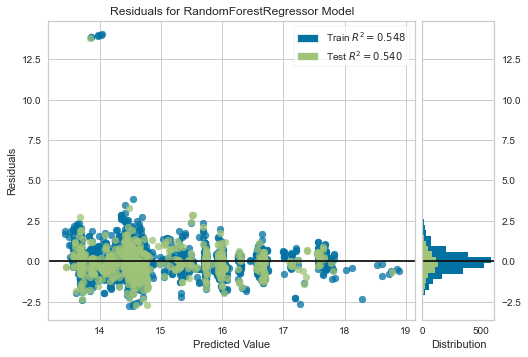

In [27]:
visualizer = ResidualsPlot(final_model_energy)
visualizer.fit(X_train, y_train.reshape(2624,))
visualizer.score(X_test, y_test.reshape(657,))
visualizer.show();

Les distributions des résidus du jeu d'entraînement et du jeu de test semblent suivre une loi normale. La distribution des résidus du jeu de test est plus aplatie. Cela peut s'expliquer par le nombre de données moins importants (seulement 20% de l'échantillon). 

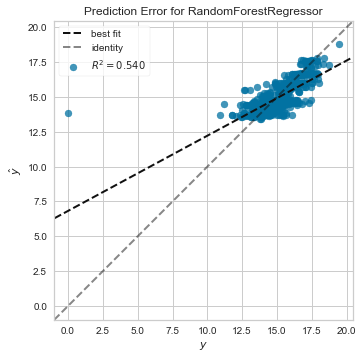

In [28]:
visualizer = prediction_error(final_model_energy, X_train, y_train, X_test, y_test);

## 2.5) Pipeline du modèle pour l'estimation de la consommation d'énergie <a class="anchor" id="section_2_5"></a>

In [29]:
from sklearn.pipeline import Pipeline

full_pipeline_energy = Pipeline([
    ("preprocessing", preprocessor),
    ("model", final_model_energy)
])

In [30]:
import joblib
 
# Sauvegarde du modèle
joblib.dump(full_pipeline_energy, 'model_prediction_energy.pkl')

['model_prediction_energy.pkl']

# 3) Prédiction des émissions de CO2 <a class="anchor" id="chapter3"></a>

Pour la prédiction des émissions de CO2, la méthode est la même que pour la prédiction de la consommation d'énergie.

## 3.1) Préparation des variables <a class="anchor" id="section_3_1"></a>

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y_ghg, test_size=0.2, random_state=42)
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [32]:
X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)

## 3.2) Création d'un modèle de base <a class="anchor" id="section_3_2"></a>

In [33]:
dummy_reg = DummyRegressor(strategy="median")
dummy_reg.fit(X_train, y_train)

DummyRegressor(strategy='median')

In [34]:
y_pred = dummy_reg.predict(X_test)

In [35]:
regression_metrics(y_test, y_pred)

MAE : 1.13086
MSE : 2.03477
RMSE : 1.42645
R² : -0.00724


## 3.3) Choix du modèle <a class="anchor" id="section_3_3"></a>

In [36]:
dummy_reg = DummyRegressor(strategy="median")
lin_reg = LinearRegression()
ridge = Ridge(random_state=42)
lasso = Lasso(random_state=42)
dt_reg =  DecisionTreeRegressor(random_state=42)
svm_reg = SVR()
ridge_kernel = KernelRidge()
adaboost = AdaBoostRegressor(random_state=42)
bagging = BaggingRegressor(random_state=42)
gdboost = GradientBoostingRegressor(random_state=42)
rdmforest = RandomForestRegressor(random_state=42)
xgboost = xgb.XGBRegressor(random_state=42)

In [37]:
model = [dummy_reg, lin_reg, ridge, lasso, dt_reg, svm_reg, ridge_kernel, adaboost, bagging, gdboost, rdmforest, xgboost]
dict_model = {}

for model in model:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** (1/2)
    r_score = r2_score(y_test, y_pred)
    dict_model[model] = (mae, mse, rmse, r_score)

eval_model = pd.DataFrame(dict_model, index=["MAE", "MSE", "RMSE", "R²"])
eval_model.columns = ["Dummy Regressor", "Linear Regression", "Ridge", "Lasso", "DecisionTree", "SVM", "Ridge Kernel",
                      "AdaBoost", "Bagging", "GradientBoosting", "Random Forest", "XGBoost"]

eval_model

,Dummy Regressor,Linear Regression,Ridge,Lasso,DecisionTree,SVM,Ridge Kernel,AdaBoost,Bagging,GradientBoosting,Random Forest,XGBoost
MAE,1.130862,0.886208,0.885764,1.130112,0.436657,0.726861,0.886961,0.876053,0.540135,0.755011,0.513588,0.532232
MSE,2.034765,1.311345,1.308132,2.022685,0.706261,0.962656,1.308875,1.147742,0.611509,0.919021,0.540426,0.591425
RMSE,1.426452,1.145140,1.143736,1.422211,0.840394,0.981150,1.144061,1.071327,0.781990,0.958656,0.735137,0.769042
R²,-0.007240,0.350864,0.352455,-0.001260,0.650390,0.523471,0.352087,0.431850,0.697294,0.545070,0.732481,0.707235


**Modèle choisi :** Random Forest

## 3.4) Choix des hyperparamètres <a class="anchor" id="section_3_4"></a>

In [38]:
forest_reg = RandomForestRegressor(max_features="auto", random_state=42)

In [39]:
param_distribs = {
        'n_estimators': randint(low=100, high=500),
        'min_samples_leaf': randint(low=1, high=5),
        'max_depth' : randint(low=1, high=3),
        "min_samples_split" : randint(low=2, high=4)
    }

random_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                             n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001C9F26AE430>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001C9F26EE2B0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001C9F26EE9A0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001C9F26E7AC0>},
                   random_state=42, scoring='neg_mean_squared_error')

In [40]:
cvres = random_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

1.2013554358325136 {'max_depth': 1, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 370}
1.2018832830424095 {'max_depth': 1, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 120}
1.201598885955749 {'max_depth': 1, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 314}
1.2012683166505869 {'max_depth': 1, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 472}
1.1235338968260127 {'max_depth': 2, 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 230}
1.1226203105349777 {'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 443}
1.1226094801527136 {'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 485}
1.1236057978595027 {'max_depth': 2, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 260}
1.1229369387319614 {'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 352}
1.1236040317010543 {'max_depth': 2, 'min_samples_leaf': 1, 'min_s

In [41]:
params = [{'n_estimators' : [400, 410, 420, 430, 440, 450, 460, 470],
           "min_samples_leaf" : [2, 3, 4],
           "max_depth": [1, 2, 3, 4],
           "min_samples_split" : [2, 3]}]

grid_search = GridSearchCV(forest_reg, params, cv=5,
                           scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_depth': [1, 2, 3, 4],
                          'min_samples_leaf': [2, 3, 4],
                          'min_samples_split': [2, 3],
                          'n_estimators': [400, 410, 420, 430, 440, 450, 460,
                                           470]}],
             scoring='neg_mean_squared_error')

In [42]:
grid_search.best_params_

{'max_depth': 4,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 460}

In [43]:
final_model_co2 = RandomForestRegressor(max_depth=4, min_samples_leaf=2, min_samples_split=2, n_estimators=260,
                                           max_features="auto", random_state=42)
final_model_co2.fit(X_train, y_train)

RandomForestRegressor(max_depth=4, min_samples_leaf=2, n_estimators=260,
                      random_state=42)

In [44]:
feature_importance = final_model_co2.feature_importances_

In [45]:
cat_encoder = preprocessor.named_transformers_["cat"]
cat_encoder = preprocessor.transformers_[0]
cat_encoder = cat_encoder[1][1]
cat_one_hot_attribs = cat_encoder.inverse_transform(X_train[:,:32])
cat_one_hot_attribs1 = list(cat_encoder.categories_[0])
cat_one_hot_attribs2 = list(cat_encoder.categories_[1])
attributes = num_var + cat_one_hot_attribs1 + cat_one_hot_attribs2

In [46]:
df_feature_imp = pd.DataFrame(feature_importance, attributes, columns=['Features Importances'])
df_feature_imp.sort_values("Features Importances", ascending=False)

,Features Importances
Southwest,0.819892
Restaurant,0.055227
K-12 School,0.033283
NumberofBuildings,0.017608
Laboratory,0.013054
NumberofFloors,0.011572
Self-Storage Facility,0.011179
Hotel,0.009474
Central,0.007665
Northeast,0.005890


## 3.5) Analyse des erreurs du modèle <a class="anchor" id="section_3_5"></a>

In [47]:
final_model_co2 = grid_search.best_estimator_

In [48]:
final_predictions_co2 = final_model_co2.predict(X_test)

In [49]:
regression_metrics(y_test, final_predictions_co2)

MAE : 0.84534
MSE : 1.10222
RMSE : 1.04987
R² : 0.45439


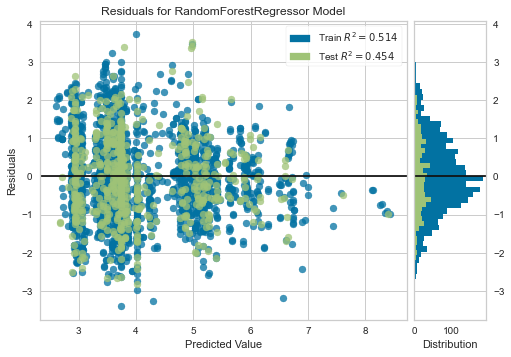

In [50]:
visualizer = ResidualsPlot(final_model_co2)
visualizer.fit(X_train, y_train.reshape(2624,))
visualizer.score(X_test, y_test.reshape(657,))
visualizer.show();

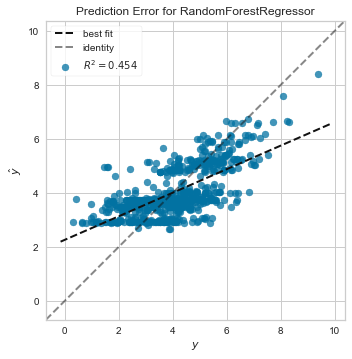

In [51]:
visualizer = prediction_error(final_model_co2, X_train, y_train, X_test, y_test);

## 3.6) Pipeline du modèle pour l'estimation des émissions de CO2 <a class="anchor" id="section_3_6"></a>

In [52]:
full_pipeline_co2 = Pipeline([
    ("preprocessing", preprocessor),
    ("model", final_model_co2)
])

In [53]:
# Sauvegarde du modèle
joblib.dump(full_pipeline_co2, 'model_prediction_co2.pkl')

['model_prediction_co2.pkl']

# 4 - Conclusion <a class="anchor" id="chapter1"></a>

A l'aide des informations dont l'on dispose, il est possible de prédire la consommation d'énergie et les émissions de CO2. Pour effectuer cela, il faudra mettre en place deux modèles de RandomForest. Les deux modèles finaux sont présents dans le script Python fourni. 

A l'intérieur, on retrouve l'entraînement et l'enregistrement des modèles. L'avantage du choix d'un modèle comme le Random Forest permet de ne pas transformer la variable cible via une transformation logarithmique. Pour les besoins de la recherche d'un modèle le plus performant possible, il était nécessaire de le faire car certains modèles sont influencés par la non-normalité de la variable cible. En revanche une fois l'étude réalisée, cela n'avait plus aucune raison d'être. C'est pourquoi le script Python des deux modèles finaux ne contient pas de transformation logarithme. Ainsi les modèles prédisent directement la consommation en énergie et les émissions de gaz à effets de serre dans l'unité que l'on a identifié dans nos données initiales. 